https://arxiv.org/pdf/1707.09520.pdf

In [1]:
import torch
from torch import tensor

from gbmi.exp_max_of_n.train import MAX_OF_10_CONFIG
from gbmi.model import train_or_load_model
import gbmi.utils as utils

import gbmi.analysis_tools.l1h1 as l1h1
import gbmi.analysis_tools.plot as plot
import gbmi.analysis_tools.decomp as decomp
import gbmi.analysis_tools.fit as fit
import gbmi.exp_max_of_n.analysis as exp_utils

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
from gbmi.utils.pretty import pprint

In [156]:
config = MAX_OF_10_CONFIG
pprint(config)

Config(
    experiment=MaxOfN(
        model_config=HookedTransformerConfig(
            n_layers=1,
            d_model=32,
            n_ctx=10,
            d_head=32,
            n_heads=1,
            d_vocab=64,
            normalization_type=None,
            device='cpu',
            attn_only=True,
            seed=613947648,
            initializer_range=float64(0.1414213562373095),
            d_vocab_out=64,
            n_params=4096
        ),
        seq_len=10,
        logging_options=ModelMatrixLoggingOptions(qpos=-1)
    ),
    validation_batch_size=128,
    train_for=(50000, 'steps'),
    validate_every=None
)


In [157]:
rundata, model = train_or_load_model(config)
model.to("cpu")

Seed set to 123
wandb:   1 of 1 files downloaded.  


Moving model to device:  cpu


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [158]:
rundata.test_metrics

[{'test_loss': 6.139447577879764e-06, 'test_acc': 1.0}]

In [159]:
config_w = utils.set_params(
    MAX_OF_10_CONFIG,
    {
        ("experiment", "optimizer_kwargs", "weight_decay"): 1e-3,
        # ("experiment", "model_config", "d_head"): 3,
    },
)
pprint(config_w)

Config(
    experiment=MaxOfN(
        model_config=HookedTransformerConfig(
            n_layers=1,
            d_model=32,
            n_ctx=10,
            d_head=32,
            n_heads=1,
            d_vocab=64,
            normalization_type=None,
            device='cpu',
            attn_only=True,
            seed=613947648,
            initializer_range=float64(0.1414213562373095),
            d_vocab_out=64,
            n_params=4096
        ),
        seq_len=10,
        logging_options=ModelMatrixLoggingOptions(qpos=-1),
        optimizer_kwargs={
            'lr': 0.001,
            'betas': (0.9, 0.999),
            'weight_decay': 0.001
        }
    ),
    validation_batch_size=128,
    train_for=(50000, 'steps'),
    validate_every=None
)


In [160]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [161]:
rundata, model = train_or_load_model(config_w)
model.to("cpu")

Seed set to 123
wandb:   1 of 1 files downloaded.  


Moving model to device:  cpu


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

We fail on sequences `[i,...,i]` for $i \leq 20$.

# Introducing the model

In [162]:
from gbmi.utils import ein
from math import sqrt
from torch import exp

U, e, p, Q, K, V, O = [
    i.squeeze().clone().detach()
    for i in [
        model.W_U,
        model.W_E,
        model.W_pos,
        model.W_Q,
        model.W_K,
        model.W_V,
        model.W_O,
    ]
]
d_head = model.cfg.d_head
d = sqrt(d_head)

s = torch.tensor([31, 30, 32, 33, 34, 35, 39, 37, 38, 36])
n = len(s)

> **NOTE:** We're using right-multiplication of matrices (i.e. $\vv{v}$ is a row-vector by default), and zero-based indexing.

Consider a 1-layer attention-only transformer, consuming a sequence of $n$ input tokens $(s_0,...,s_{n-1})$, with
- hidden dimension $h$
- head dimension $d_{head}$
- vocabulary size $v$ (representing numbers 0 to $v-1$ with token indices 0 to $v-1$)

Let $d = \sqrt{d_{head}}$, $\vv{e}_t = (W_E)_t$, and $\vv{p}_i = (W_{pos})_i$.

Then the unnormalised attention from position $n-1$ (storing token $s_{n-1}$) to position $i_q$ (storing token $s_{i_q}$) is given by
$$\alpha(s_{n-1}, s_{i_q}, i_q) = \f{1}{d} (\vv{e}_{s_{n-1}} + \vv{p}_{n-1}) Q K^T (\vv{e}_{s_{i_q}} + \vv{p}_{i_q})^T$$

In [163]:
α = ein.array(
    lambda s_n1, s_i_q, i_q: (1 / d)
    * (e[s_n1] + p[n - 1])
    @ Q
    @ K.T
    @ (e[s_i_q] + p[i_q]).T
)

and the output logit vector (at position ${n-1}$) is given by
$$\vv{y}(\vv{s}) = \f{1}{\sum_{i=0}^{{n-1}} e^{\alpha(s_{n-1}, s_i, i)}} 
\left[\sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i)} (\vv{e}_{s_i} + \vv{p}_i)VOU\right]
+ (\vv{e}_{s_{n-1}} + \vv{p}_{n-1})U$$
such that $y_i(\vv{s})$ corresponds to the output logit for token $i\in \cbr{0, ...,v-1}$.

In [164]:
y = lambda s: (
    (
        1
        / ein.sum(lambda i: exp(α[s[n - 1], s[i], i]))
        * ein.sum(lambda i: exp(α[s[n - 1], s[i], i]) * (e[s[i]] + p[i]) @ V @ O @ U)
    )
    + (e[s[n - 1]] + p[n - 1]) @ U
)
true_logits = model(torch.tensor(s))
assert torch.allclose(y(torch.tensor(s)), true_logits.squeeze()[-1], atol=1e-5)

/var/folders/y1/33lbjdps12lf6x0csm_rvb5m0000gn/T/ipykernel_66125/1627245852.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_logits = model(torch.tensor(s))
/var/folders/y1/33lbjdps12lf6x0csm_rvb5m0000gn/T/ipykernel_66125/1627245852.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert torch.allclose(y(torch.tensor(s)), true_logits.squeeze()[-1], atol=1e-5)


Alternatively, we can write $y_t(\vv{s})$ in terms of

- the _residual logit contribution for $t$ from position $n-1$ (with value $s_{n}$)_:

$$r(t, s_{{n-1}}) = [(\vv{e}_{s_{{n-1}}} + \vv{p}_{{n-1}})U]_t$$

- the _OV logit contribution for $t$ from position $i$ (with value $s_i$)_:

$$v(t, i, s_i) = [(\vv{e}_{s_iz} + \vv{p}_i)VOU]_t$$

as

$$y_t(\vv{s}) = \f{1}{\sum_{i=0}^{{n-1}} e^{\alpha(s_{n-1}, s_i, i)}} 
\left[\sum_{i=0}^{n-1} e^{\alpha(s_{{n-1}}, s_i, i)} v(t, i, s_i)\right]
+ r(t, s_{{n-1}})$$

In [165]:
r = ein.array(lambda t, s_n1: ((e[s_n1] + p[n - 1]) @ U)[t])
v = ein.array(lambda t, i, s_i: ((e[s_i] + p[i]) @ V @ O @ U)[t])

In [166]:
y_t = lambda t, s: (
    1
    / ein.sum(lambda i: exp(α[s[n - 1], s[i], i]))
    * ein.sum(lambda i: exp(α[s[n - 1], s[i], i]) * v[t, i, s[i]])
    + r[t, s[n - 1]]
)

In [167]:
assert torch.allclose(y_t(0, s), true_logits.squeeze()[-1, 0], atol=1e-5)

In [168]:
(O @ U).shape

torch.Size([32, 64])

In [169]:
EV = e @ V
OU = (O @ U).T

In [170]:
b1 = 100
b2 = 1000
n = 64
d = 32
lin = torch.linspace(0, 1, b1)
points = torch.normal(0, 1, (b1, b2, n, d))
normalised = ein.array(
    lambda b1, b2, n_i, d_i: points[b1, b2, n_i, d_i]
    / torch.sqrt(ein.sum(lambda d_j: points[b1, b2, n_i, d_j] ** 2))
)

In [171]:
import matplotlib.pyplot as plt

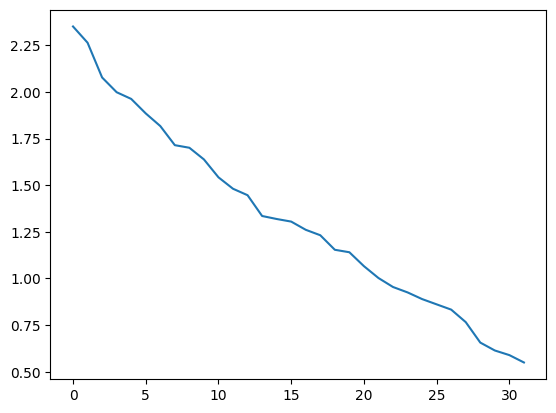

In [172]:
plt.plot(torch.linalg.svd(normalised[0, 0]).S)
plt.show()

In [173]:
plt.plot(lin, ((arr.argmax(-1) == torch.arange(n)) * 1.0).mean(dim=-1).mean(dim=-1))
plt.xlabel("Std of error")
plt.ylabel("Argmax accuracy")
plt.show()

RuntimeError: The size of tensor a (44) must match the size of tensor b (64) at non-singleton dimension 0

In [ ]:
n = 64
d = 32

points = torch.normal(0, 1, (n, d))
normalised = ein.array(
    lambda n_i, d_i: points[n_i, d_i]
    / torch.sqrt(ein.sum(lambda d_j: points[n_i, d_j] ** 2))
)
show_with_max_elt(
    (normalised + torch.normal(0, 0.1, normalised.shape))
    @ (normalised + torch.normal(0, 0.1, normalised.shape)).T
)

In [ ]:
plt.plot(torch.linalg.svd(e @ V).S)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(torch.linalg.svd(O @ U).S)
plt.show()

In [ ]:
(e @ V).shape

In [ ]:
(O @ U).shape

In [ ]:
from scipy.spatial import KDTree

In [ ]:
points = (O @ U).T

KDTree(points).leafsize

In [ ]:
torch

In [ ]:
O @ U

In [ ]:
embeds = (O @ U).T

plt.hist(torch.linalg.norm(embeds[38:], dim=1))
plt.hist(torch.linalg.norm(embeds[:38], dim=1))
plt.show()

In [ ]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt()
Z = np.sin(R)
plt.imshow(Z)

In [ ]:
embeds = e @ V

plt.plot(torch.linalg.norm(embeds[:], dim=1))
plt.show()

In [ ]:
embeds = (O @ U).T

plt.plot(torch.linalg.norm(embeds[:], dim=1))
plt.show()

In [ ]:
from gbmi.utils import ein

EV = e @ V
OU = (O @ U).T
EV_rescaled = EV / torch.linalg.norm(EV, dim=1)[:, None]
OU_rescaled = OU / torch.linalg.norm(OU, dim=1).max()
# plot, for each i, (OU - EV_rescaled[i].T).norm(dim=1)

# plot (EV_rescaled - OU_rescaled).norm(dim=1)
# plot over all pairs i, j (OU_rescaled[i, :] - OU_rescaled[j, :]).norm(dim=1)

In [ ]:
plt.plot((EV_rescaled - OU_rescaled).norm(dim=1))

In [174]:
OU_rescaled *= 2

In [175]:
ein.array(lambda i: OU_rescaled[i])

tensor([[-0.1765,  0.2585, -0.5128,  ...,  0.2171, -0.0101, -0.4396],
        [-0.2021,  0.3003, -0.6727,  ...,  0.1428, -0.0348, -0.2966],
        [ 0.0071,  0.1247, -0.5455,  ...,  0.2101,  0.0202, -0.3282],
        ...,
        [-0.8311,  0.6598, -0.6560,  ..., -0.2568,  0.8957,  0.8252],
        [-0.7832,  0.5503, -0.8672,  ...,  0.5988, -0.2052,  0.4183],
        [-0.5780,  0.9887, -0.0070,  ..., -0.3024,  0.1930,  0.8211]])

In [176]:
A = torch.tensor([0, 0, 0])
total = 0
for i in range(3):
    total += ein.array(lambda i: A[i]).sum()
    A += 1
print(total)

tensor(0)


In [177]:
import numpy as np


def show_with_min_elt(data):
    # Display the original image
    plt.imshow(data)

    # Get the index of the max-valued pixel in each row
    max_indices = np.argmin(data, axis=1)

    # Get the range of row numbers
    rows = np.arange(data.shape[0])

    # Plot a red dot at the max-valued pixel of each row
    plt.scatter(max_indices, rows, color="red", s=10)  # s is the size of the dot

    # Show the plot with the red dots
    plt.show()


import numpy as np


def show_with_max_elt(data):
    # Display the original image
    plt.imshow(data)

    # Get the index of the max-valued pixel in each row
    max_indices = np.argmax(data, axis=1)

    # Get the range of row numbers
    rows = np.arange(data.shape[0])

    # Plot a red dot at the max-valued pixel of each row
    plt.scatter(max_indices, rows, color="red", s=10)  # s is the size of the dot

    # Show the plot with the red dots
    plt.show()

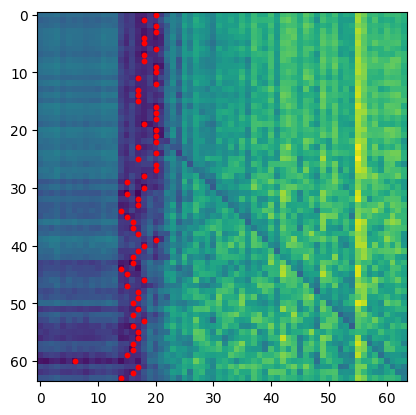

In [178]:
show_with_min_elt(
    ein.array(lambda i, j: (EV_rescaled[i, :] - OU_rescaled[j, :]).norm())
)

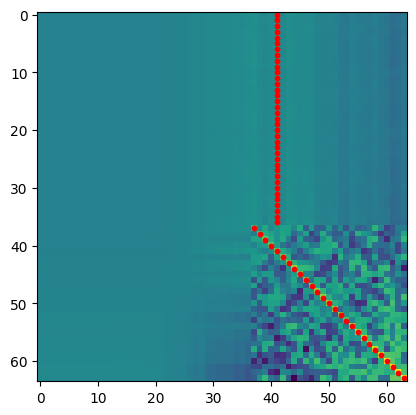

In [196]:
show_with_max_elt(ein.array(lambda i, j: (e @ V)[i] @ OU[j]))

(array([ 44.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   2.,   0.,   2.,   2.,   2.,   2.,  18.,  16.,  44.,  30.,
         46.,  56.,  60.,  62.,  88.,  96., 106., 122., 114., 108.,  84.,
        102., 108., 112.,  88.,  82.,  58.,  76.,  58.,  38.,  34.,  20.,
         22.,  20.,   2.,   2.,   2.,   6.]),
 array([0.        , 0.13123657, 0.26247314, 0.39370969, 0.52494627,
        0.65618283, 0.78741938, 0.91865593, 1.04989254, 1.1811291 ,
        1.31236565, 1.4436022 , 1.57483876, 1.70607531, 1.83731186,
        1.96854842, 2.09978509, 2.23102164, 2.3622582 , 2.49349475,
        2.6247313 , 2.75596786, 2.88720441, 3.01844096, 3.14967752,
        3.28091407, 3.41215062, 3.54338717, 3.67462373, 3.80586028,
        3.93709683, 4.06833363, 4.19957018, 4.33080673, 4.46204329,
        4.59327984, 4.72451639, 4.85575294, 4.9869895 , 5.11822605,
        5.2494626 , 5.38069916, 5.51193571, 5.64317226, 5.77440882,
        5.90564537, 6.03688192, 6.16811848, 6.

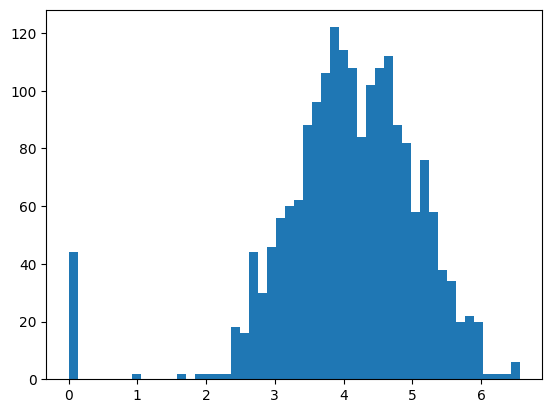

In [180]:
plt.hist(
    ein.array(lambda i, j: (OU_rescaled[i, :] - OU_rescaled[j, :]).norm())[
        20:, 20:
    ].flatten(),
    bins=50,
)

(array([ 44.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   2.,   2.,   2.,   0.,   8.,   6.,   6.,
         16.,  26.,  20.,  44.,  42.,  48.,  70.,  90.,  90.,  76.,  58.,
         72., 108., 102., 112., 100., 120., 122.,  72., 100.,  92.,  70.,
         58.,  50.,  38.,  46.,  20.,   2.]),
 array([0.        , 0.03863765, 0.07727529, 0.11591294, 0.15455058,
        0.19318822, 0.23182587, 0.27046353, 0.30910116, 0.3477388 ,
        0.38637644, 0.42501411, 0.46365175, 0.50228941, 0.54092705,
        0.57956469, 0.61820233, 0.65683997, 0.6954776 , 0.73411524,
        0.77275288, 0.81139058, 0.85002822, 0.88866585, 0.92730349,
        0.96594113, 1.00457883, 1.04321647, 1.0818541 , 1.12049174,
        1.15912938, 1.19776702, 1.23640466, 1.2750423 , 1.31367993,
        1.35231757, 1.39095521, 1.42959285, 1.46823049, 1.50686812,
        1.54550576, 1.5841434 , 1.62278116, 1.6614188 , 1.70005643,
        1.73869407, 1.77733171, 1.81596935, 1.

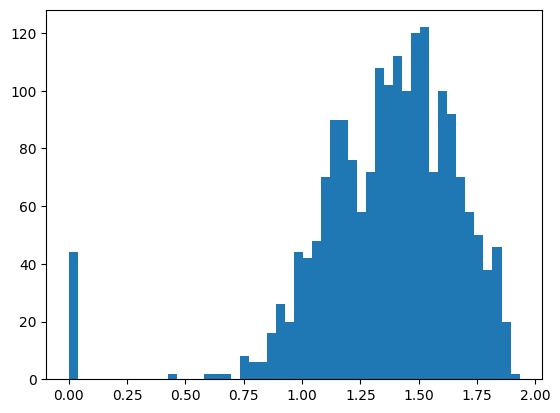

In [181]:
plt.hist(
    ein.array(lambda i, j: (EV_rescaled[i, :] - EV_rescaled[j, :]).norm())[
        20:, 20:
    ].flatten(),
    bins=50,
)

# Orthogonal matrix

In [197]:
import torch
import torch.nn as nn
from torch import where, Tensor
from jaxtyping import Float
import eintorch as ein

In [198]:
class OrthogonalMatrixGen(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx, A: Float[Tensor, "h h"], D: Float[Tensor, "h h"]
    ) -> Float[Tensor, "h h"]:
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        I = torch.eye(A.shape[0])
        W = torch.linalg.inv(I + A) @ (I - A) @ D
        ctx.save_for_backward(W, A, D)
        return W

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        W, A, D = ctx.saved_tensors
        I = torch.eye(A.shape[0])
        V = torch.linalg.inv(I + A).T @ grad_output @ (D + W.T)
        return V.T - V, None

In [199]:
class OrthogonalMatrix(nn.Module):
    def __init__(self, n_dims, n_minus=None):
        super().__init__()
        if n_minus is None:
            n_minus = n_dims // 2
        # Initialise
        n = n_dims
        t = torch.rand(n) * (torch.pi / 2)
        s = torch.sqrt((1 - torch.cos(t)) / (1 + torch.cos(t)))

        init = ein.array(
            lambda i, j: where((i % 2 == 0) & (i + 1 == j), s[i // 2], 0), size=(n, n)
        )
        init = ein.array(
            lambda i, j: where((i % 2 == 1) & (i - 1 == j), -s[i // 2], init[i, j]),
            size=(n, n),
        )

        self.n_dims = n_dims
        self.A = nn.Parameter(init - init.T)

        diag_vals = torch.ones(n_dims)
        diag_vals[-n_minus:] = -1
        self.D = torch.diag(diag_vals)

    @property
    def mat(self):
        return OrthogonalMatrixGen.apply(self.A, self.D)

In [200]:
import lightning as pl
from jaxtyping import Float, Int
from typing import Tuple
from torch import Tensor
import torch.nn.functional as F


class Destructurer(pl.LightningModule):
    def __init__(self, embeds: Float[Tensor, "b h"]):
        super().__init__()
        self.embeds = embeds
        self.ortho = OrthogonalMatrix(self.embeds.shape[1])

    def training_step(
        self, batch: Tuple[Float[Tensor, "b h"], Int[Tensor, "b"]], batch_idx
    ):
        # learn an affine translation to centre the cube?
        transformed_embeds = self.embeds @ self.ortho.mat

        normalised_embeds = F.normalize(transformed_embeds, dim=1)
        loss = F.tanh(torch.abs(normalised_embeds)).mean()

        # loss = torch.linalg.norm(normalised_embeds, ord=1, dim=1).mean() + torch.linalg.norm(normalised_embeds, ord=1, dim=0).mean()
        # loss = torch.abs(F.normalize(transformed_embeds, dim=1)).sum()
        self.log("loss", loss, prog_bar=True)
        return loss

    # def validation_step(self, batch: Tuple[Float[Tensor, "b h"], Int[Tensor, "b"]], batch_idx):
    #     x, y = batch
    #     y_preds = self.proj(x)
    #     loss = F.cross_entropy(y_preds, y)
    #     self.log("val_loss", loss, prog_bar=True)
    #     acc = ((y_preds.argmax(dim=-1) == y) * 1.0).mean()
    #     self.log("val_acc", acc, prog_bar=True)

    # def test_step(self, batch: Tuple[Float[Tensor, "b h"], Int[Tensor, "b"]], batch_idx):
    #     x, y = batch
    #     y_preds = self.proj(x)
    #     loss = F.cross_entropy(y_preds, y)
    #     self.log("test_loss", loss, prog_bar=True)
    #     acc = ((y_preds.argmax(dim=-1) == y) * 1.0).mean()
    #     self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [201]:
(e @ V).shape, (O @ U).shape

(torch.Size([64, 32]), torch.Size([32, 64]))

In [202]:
from torch.utils.data import DataLoader

In [203]:
from lightning.pytorch.callbacks import RichProgressBar


embeds = (O @ U).T
model = Destructurer(embeds[37:])

In [216]:
trainer = pl.Trainer(
    enable_progress_bar=True,
    accelerator="cpu",
    max_epochs=10000,
    check_val_every_n_epoch=100,  # check every epoch
    callbacks=[RichProgressBar(refresh_rate=1000)],
)
empty_loader = DataLoader([[]], batch_size=1)
trainer.fit(model, empty_loader)

Epoch 1926/9999 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/1 0:00:00 • 0:00:00 0.00it/s v_num: 27.000 loss: 0.056

In [227]:
# torch.save(model.state_dict(), "tanh_weight_decay.pth")

In [223]:
torch.linalg.det(model.ortho.mat)

tensor(1.0000, grad_fn=<LinalgDetBackward0>)

In [ ]:
model.load_state_dict(torch.load("tanh_weight_decay.pth"))

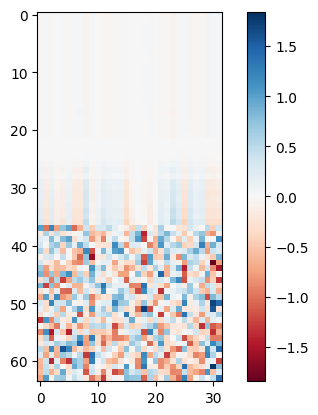

In [228]:
mat = embeds
import numpy as np
import matplotlib.pyplot as plt

# Assuming active_dims is your data array
max_abs_value = torch.max(
    torch.abs(mat)
)  # Find the maximum absolute value in the array

plt.imshow(mat, cmap="RdBu", vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar()  # Optionally add a colorbar to see the mapping
plt.show()

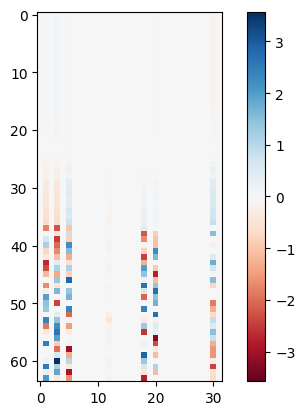

In [229]:
mat = (embeds @ model.ortho.mat).detach()
import numpy as np
import matplotlib.pyplot as plt

# Assuming active_dims is your data array
max_abs_value = torch.max(
    torch.abs(mat)
)  # Find the maximum absolute value in the array

plt.imshow(mat, cmap="RdBu", vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar()  # Optionally add a colorbar to see the mapping
plt.show()

In [230]:
rows = (embeds @ model.ortho.mat)[37:].detach()

In [231]:
# active_dims = rows[:,[1,2,3,5,12,18,19,20,30]]
active_dims = rows[:, [1, 3, 5, 18, 20, 30]]

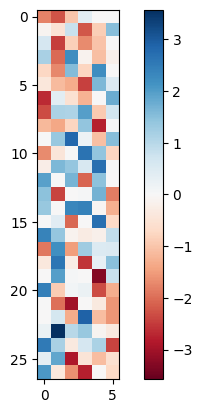

In [232]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming active_dims is your data array
max_abs_value = torch.max(
    torch.abs(active_dims)
)  # Find the maximum absolute value in the array

plt.imshow(active_dims, cmap="RdBu", vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar()  # Optionally add a colorbar to see the mapping
plt.show()

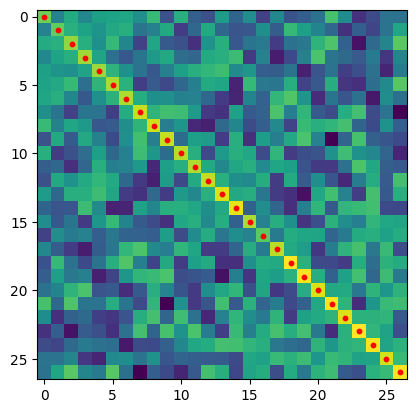

In [233]:
show_with_max_elt(ein.array(lambda i, j: active_dims[i] @ active_dims[j]))

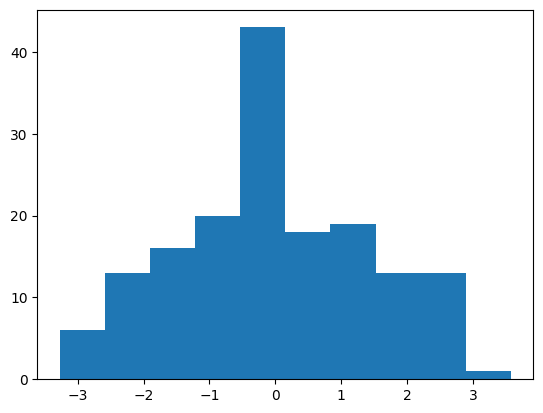

In [234]:
plt.hist(active_dims.flatten())
plt.show()

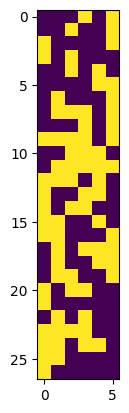

In [235]:
plt.imshow(active_dims > 0)
plt.show()

In [236]:
nums = [
    int(i)
    for i in ein.array(
        lambda h, i: 2**i * (active_dims[h, i] > 0), sizes=(None, 9)
    ).sum(-1)
]
len(nums), len(set(nums))

(27, 24)

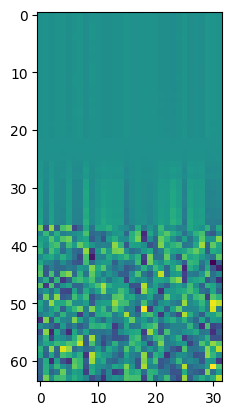

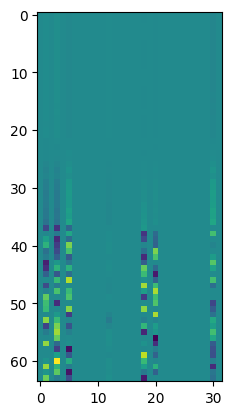

In [224]:
# L1 norm 'across' and 'down'
plt.imshow((embeds).detach())
plt.show()
plt.imshow((embeds @ model.ortho.mat).detach())

In [215]:
model.load_state_dict(torch.load("l1_across_down.pth"))

<All keys matched successfully>

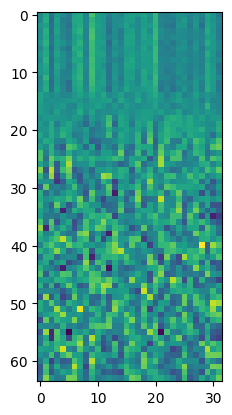

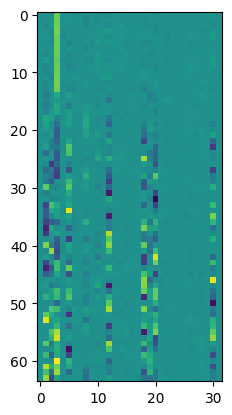

In [149]:
# L1 norm 'across' and 'down'
plt.imshow((embeds).detach())
plt.show()
plt.imshow((embeds @ model.ortho.mat).detach())

In [150]:
import eintorch as ein

In [151]:
rows = (embeds @ model.ortho.mat)[20:].detach()

In [152]:
# active_dims = rows[:,[1,2,3,5,12,18,19,20,30]]
active_dims = rows[:, [1, 2, 3, 5, 12, 18, 20, 30]]

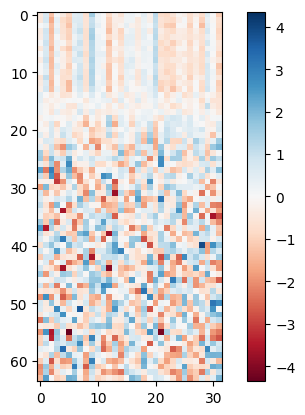

In [154]:
mat = embeds
import numpy as np
import matplotlib.pyplot as plt

# Assuming active_dims is your data array
max_abs_value = torch.max(
    torch.abs(mat)
)  # Find the maximum absolute value in the array

plt.imshow(mat, cmap="RdBu", vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar()  # Optionally add a colorbar to see the mapping
plt.show()

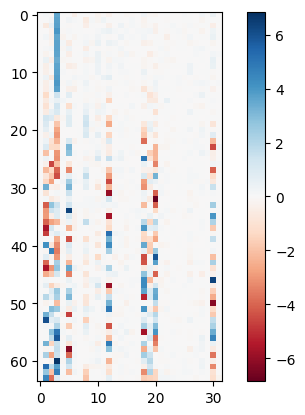

In [155]:
mat = (embeds @ model.ortho.mat).detach()
import numpy as np
import matplotlib.pyplot as plt

# Assuming active_dims is your data array
max_abs_value = torch.max(
    torch.abs(mat)
)  # Find the maximum absolute value in the array

plt.imshow(mat, cmap="RdBu", vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar()  # Optionally add a colorbar to see the mapping
plt.show()

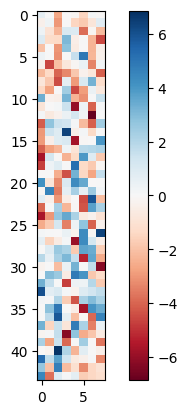

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming active_dims is your data array
max_abs_value = torch.max(
    torch.abs(active_dims)
)  # Find the maximum absolute value in the array

plt.imshow(active_dims, cmap="RdBu", vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar()  # Optionally add a colorbar to see the mapping
plt.show()

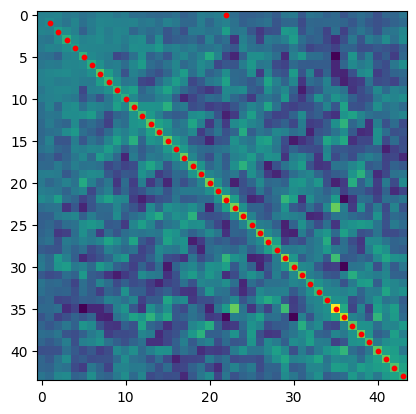

In [118]:
show_with_max_elt(ein.array(lambda i, j: active_dims[i] @ active_dims[j]))

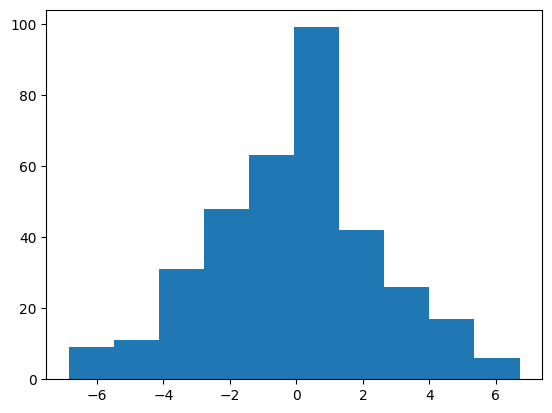

In [119]:
plt.hist(active_dims.flatten())
plt.show()

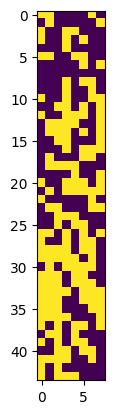

In [120]:
plt.imshow(active_dims > 0)
plt.show()

In [122]:
nums = [
    int(i)
    for i in ein.array(
        lambda h, i: 2**i * (active_dims[h, i] > 0), sizes=(None, 9)
    ).sum(-1)
]
len(nums), len(set(nums))

(44, 43)

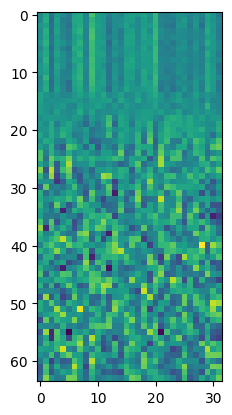

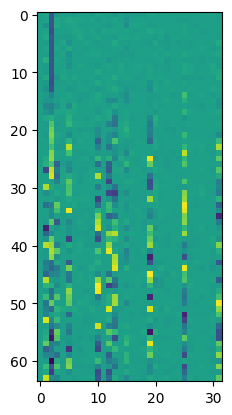

In [77]:
# L 0.6 norm
plt.imshow((embeds).detach())
plt.show()
plt.imshow((embeds @ model.ortho.mat).detach())

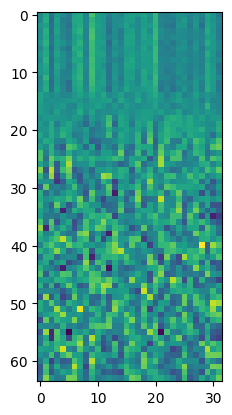

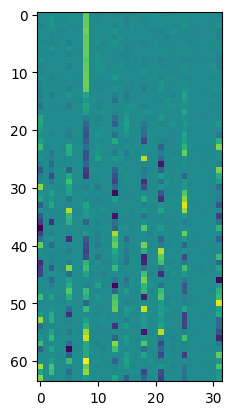

In [64]:
# L 1 norm

plt.imshow((embeds).detach())
plt.show()
plt.imshow((embeds @ model.ortho.mat).detach())

In [229]:
embeds

tensor([[-0.0174,  0.0208, -0.0329,  ...,  0.0518,  0.0329,  0.0160],
        [-0.0174,  0.0210, -0.0330,  ...,  0.0516,  0.0332,  0.0161],
        [-0.0174,  0.0208, -0.0336,  ...,  0.0527,  0.0338,  0.0155],
        ...,
        [-0.6378,  0.4443, -0.2634,  ...,  0.1803,  1.7857,  0.7626],
        [-0.5820,  0.4712, -0.6520,  ...,  1.0809, -0.5286,  0.2338],
        [-0.7291,  1.0252, -0.1081,  ..., -0.0299,  0.4191,  1.3887]])

In [ ]:
VO

In [103]:
torch.linalg.det(OrthogonalMatrix(100).mat)

tensor(1.0000, grad_fn=<LinalgDetBackward0>)

In [64]:
torch.linalg.det

<function torch._C._linalg.linalg_det>

In [12]:
diag_vals = torch.ones(10)
n_minus = 4
n = 10

In [13]:
diag_vals[-n_minus:] = -1

In [14]:
diag_vals

tensor([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.])

In [26]:
t = torch.rand(n) * (torch.pi / 2)
s = torch.sqrt((1 - torch.cos(t)) / (1 + torch.cos(t)))

In [27]:
from gbmi.utils import ein

In [35]:
init = ein.array(
    lambda i, j: where((i % 2 == 0) & (i + 1 == j), s[i // 2], 0), sizes=(n, n)
)
init = ein.array(
    lambda i, j: where((i % 2 == 1) & (i - 1 == j), -s[i // 2], init[i, j]),
    sizes=(n, n),
)

In [36]:
init

tensor([[ 0.0000,  0.9607,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.9607,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.7764,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.7764,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0160,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0160,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7980,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7980,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.2574],
        [ 0.0000,  